# 데이터를 정제하고 다시 넣어도 1시간40분
- Dict 형태의 문제인가?
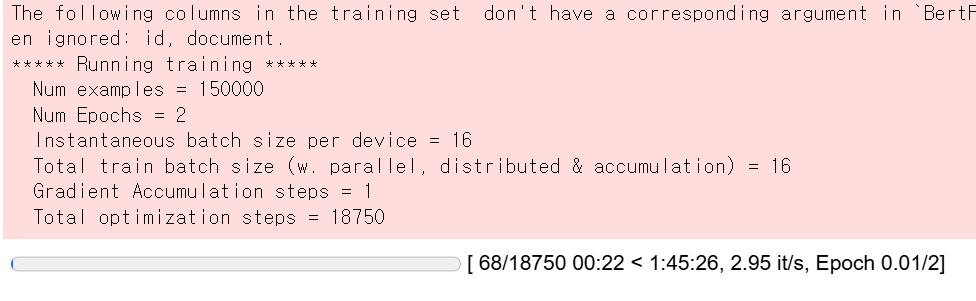


- Dict 형태를 제거해도 시간이 똑같다
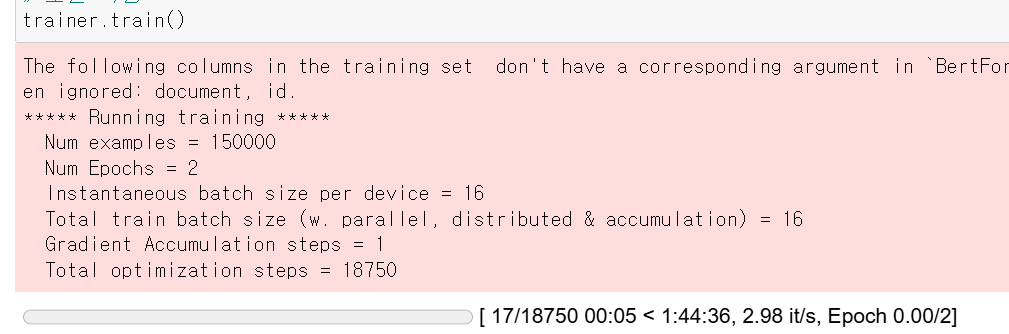

In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import transformers 
import datasets
from datasets import Dataset, DatasetDict

from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification

In [2]:
dataset = load_dataset('nsmc')
dataset

Using custom data configuration default
Reusing dataset nsmc (/aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})

In [3]:
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base", num_labels=2)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})

In [5]:
train_df = dataset['train'].to_pandas()
test_df = dataset['test'].to_pandas()# Dataset을 DataFrame으로 변환

In [6]:
train_dataset = train_df.to_dict('list')
test_dataset = test_df.to_dict('list')

# # Huggingface dataset
tf_train_dataset = Dataset.from_dict(train_dataset)
tf_test_dataset = Dataset.from_dict(test_dataset)

In [7]:
dataset_dict = DatasetDict({
    "train": tf_train_dataset,
    "test": tf_test_dataset,# train 데이터셋으로 추가
    # "test": test_data  # test 데이터가 있다면 추가 가능
})

dataset_dict

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})

In [8]:
# 데이터 전처리 함수 정의
def preprocess(data):
    return tokenizer(data['document'], truncation=True, padding="max_length", max_length=128)

# 전처리된 데이터셋 생성
tokenized_dataset = tf_train_dataset.map(preprocess, batched=True)

# 학습 및 평가에 필요한 데이터셋 형식으로 변환
# tokenized_dataset = tokenized_dataset.rename_column("label", "labels")  # 'label'을 'labels'로 변경
tokenized_dataset.set_format("torch")  # PyTorch 텐서 형식으로 설정

  0%|          | 0/150 [00:00<?, ?ba/s]

In [9]:
# 모델 성능 평가를 위한 정확도 계산 함수
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [10]:
# TrainingArguments 설정

training_args = TrainingArguments(
    output_dir = os.getenv('HOME')+'/aiffel/transformers',
    evaluation_strategy="epoch",
    learning_rate=2e-5,  # 학습률 조정
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,  # 필요한 경우 epoch 수 조정
    weight_decay=0.01,
)

In [12]:
# Trainer 설정
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
#     eval_dataset=tokenized_dataset['test'],
    compute_metrics=compute_metrics,
)

# 모델 학습
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running training *****
  Num examples = 150000
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 18750


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 